#Google Drive Authetication



In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Installing Transformers

In [ ]:
!pip install transformers==3.0.0

     |████████████████████████████████| 754 kB 9.7 MB/s 
     |████████████████████████████████| 1.2 MB 61.5 MB/s 
     |████████████████████████████████| 895 kB 60.4 MB/s 
     |████████████████████████████████| 3.0 MB 57.3 MB/s 


In [ ]:
#@title Importing Libraries

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import shutil
import re
import logging
logging.basicConfig(level=logging.ERROR)

#import warnings
#warnings.filterwarnings("ignore")

#GPU device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda:0


#REad data

In [ ]:
file = open("/content/drive/MyDrive/1-restaurant-train.csv",'r')
contents = file.read()


In [ ]:
x = contents.split("\n")
x=x[:30001]

In [ ]:
text=[]
ratings=[]
id=[]
count=1
for i in range(len(x)-1):
  temp = x[i].split("\t")
  text.append(temp[1])
  ratings.append(temp[0])
  id.append(count)
  count=count+1
testing_set = pd.DataFrame(list(zip(id,text, ratings)),columns =['id','text', 'Ratings'])

In [ ]:
polarity_new=[]
for each_example in testing_set.itertuples():

  if each_example.Ratings=='4' or each_example.Ratings=='5':
    polarity_new.append("positive")

  elif each_example.Ratings=='3':
    polarity_new.append("neutral")

  else:
    polarity_new.append("negative")

testing_set['polarity']=polarity_new

In [ ]:
testing_set.head()

,id,text,Ratings,polarity
0,1,Thank you thank you thank you !! I want to th...,4,positive
1,2,A Humane Society store at the Biltmore? Inter...,5,positive
2,3,Don't buy Nike sneakers if you want to return ...,1,negative
3,4,I have to say I love most things about Sprouts...,3,neutral
4,5,The tire pressure light came on a day or so ag...,5,positive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


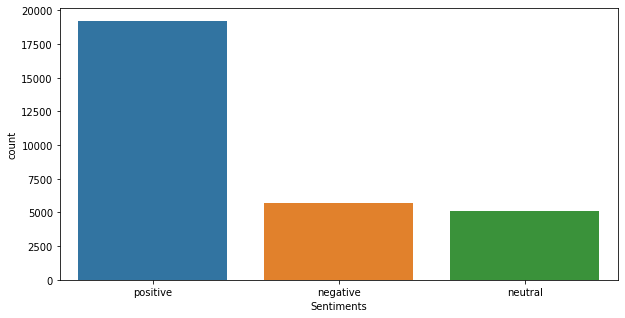

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(testing_set.polarity)
plt.xlabel('Sentiments')
plt.show()

In [ ]:
positive_df = testing_set[testing_set['polarity']=='positive']
negative_df = testing_set[testing_set['polarity']=='negative']
neutral_df = testing_set[testing_set['polarity']=='neutral']



In [ ]:
pos_df = positive_df.sample(n=len(negative_df),replace=False)

In [ ]:
frames = [pos_df, negative_df, neutral_df]

new_df = pd.concat(frames)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


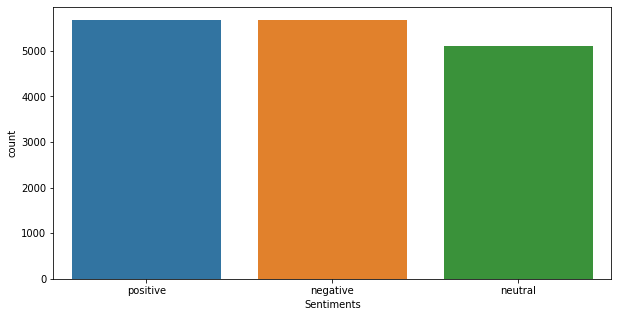

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(new_df.polarity)
plt.xlabel('Sentiments')
plt.show()

In [ ]:
new_df.head()

,id,text,Ratings,polarity
29977,29978,I love this Super Target so much I am compelle...,5,positive
11617,11618,"""""""Four of us dined there on Christmas Eve and...",5,positive
3556,3557,The only thing you can say critically about th...,4,positive
14533,14534,The only thing that I would have liked better ...,4,positive
3085,3086,Michael's is my favorite place to have things ...,5,positive


In [ ]:
new_df = new_df.sample(frac = 1).reset_index(drop=True)

In [ ]:
new_df.head()

,id,text,Ratings,polarity
0,22181,"I've only ordered once. I had wonton soup, sh...",3,neutral
1,20327,I wish I didn't have to give ONE STAR uhgg .. ...,1,negative
2,12051,"Dear Paradise Mall, \n\nOh you poor thing !! Y...",3,neutral
3,8388,"""""""Terrible Customer Service.\n\nAs I was driv...",1,negative
4,16859,"""""""The pool area is 5 star. The beds, 1 star....",3,neutral


In [ ]:
polarity_new=[]
for each_example in new_df.itertuples():

  if each_example.polarity=='positive':
    polarity_new.append(0)

  elif each_example.polarity=='negative':
    polarity_new.append(1)

  else:
    polarity_new.append(2)

new_df['polarity_new']=polarity_new


In [ ]:
new_df.head()

,id,text,Ratings,polarity,polarity_new
0,22181,"I've only ordered once. I had wonton soup, sh...",3,neutral,2
1,20327,I wish I didn't have to give ONE STAR uhgg .. ...,1,negative,1
2,12051,"Dear Paradise Mall, \n\nOh you poor thing !! Y...",3,neutral,2
3,8388,"""""""Terrible Customer Service.\n\nAs I was driv...",1,negative,1
4,16859,"""""""The pool area is 5 star. The beds, 1 star....",3,neutral,2


In [ ]:
import string, nltk
#nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
from bs4 import BeautifulSoup

lemmatizer = nltk.stem.WordNetLemmatizer()
def preprocess(text):
    text = str(text)
    soup = BeautifulSoup(text, "html.parser")
    for data in soup(['script', 'style']):
        data.decompose()
    text = ' '.join(soup.stripped_strings)
    #text = text.lower()
    temp = ""
    for i in text:
        if i in string.punctuation:
            continue
        else:
            temp+=i
    temp = temp.split()
    #temp = [w for w in temp if w not in nltk.corpus.stopwords.words('english')]
    for i in range(len(temp)):
        temp[i] = lemmatizer.lemmatize(temp[i])
    return ' '.join(temp)
new_df['text'] = new_df['text'].apply(preprocess)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
new_df.head()

,id,text,Ratings,polarity,polarity_new
0,22181,Ive only ordered once I had wonton soup shrimp...,3,neutral,2
1,20327,I wish I didnt have to give ONE STAR uhgg nnTh...,1,negative,1
2,12051,Dear Paradise Mall nnOh you poor thing You nee...,3,neutral,2
3,8388,Terrible Customer ServicennAs I wa driving pas...,1,negative,1
4,16859,The pool area is 5 star The bed 1 star Holy co...,3,neutral,2


#BERT Model

In [ ]:
class SentimentClassifier(nn.Module):
  """
  This class defines the model architecture which is simply a fully-connected
  layer on top of a pre-trained BERT model. 
  """

  def __init__(self, BERT_MODEL):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, 3) # Number of output classes = 3

  def forward(self, ids, mask, token_type_ids):
    last_hidden_state, pooled_output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
from torchsummary import summary
BERT_MODEL = 'bert-base-uncased'
model = SentimentClassifier(BERT_MODEL)
model = model.to(device)


In [ ]:
class util_tokenizer:
  """
  This class tokenizes the input text using the pre-trained BERT tokenizer 
  (wordpiece) and returns the corresponding tensors.
  """

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.targets = targets

  def __len__(self):
    return len(self.targets)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    targets = self.targets[item]

    inputs = self.tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.max_len,
        pad_to_max_length = True
    )

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(targets, dtype=torch.long)
    }

In [ ]:
def loss_function(outputs, targets):
	"""
	This function defines the loss function which is used to train the model, i.e.
	CrossEntropy.
	"""
	return nn.CrossEntropyLoss(reduction='mean')(outputs, targets)

In [ ]:
def validation(model, data):
    #imgs, labels = data[0].to(device), data[1].to(device)
    ids = data["ids"].to(device, dtype=torch.long)
    mask = data["mask"].to(device, dtype=torch.long)
    token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)

    targets = data["targets"].to(device, dtype=torch.long)
    
    pred =  model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    loss = loss_function(pred, targets)
    return loss.item()

In [ ]:
def train_loop_function(data_loader, model, optimizer, device):
  """
  This function defines the training loop over the entire training set.
  """

  model.train()
  loss_list =[]

  running_loss = 0.0
  for bi, d in enumerate(data_loader):
    ids = d["ids"]
    mask = d["mask"]
    token_type_ids = d["token_type_ids"]
    targets = d["targets"]

    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.long)

    optimizer.zero_grad()

    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    loss = loss_function(outputs, targets)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()


    if bi % 10 == 0 and bi!=0:
      temp = f'Batch index = {bi}\tLoss = {running_loss/10}'
      loss_list.append(running_loss/10)
      running_loss = 0.0
  return loss_list


In [ ]:
def eval_loop_function(data_loader, model, device):
  """
  This function defines the evaluation loop over the entire validation set.
  It also computes accuracy of the trained model, which is used to select the 
  best model.
  """

  model.eval()

  corrects = 0
  total = 0
  for bi, d in enumerate(data_loader):
    ids = d["ids"]
    mask = d["mask"]
    token_type_ids = d["token_type_ids"]
    targets = d["targets"]

    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.long)

    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

    _, predicted = torch.max(outputs, 1)
    total = total + targets.size(0)
    corrects = corrects + (predicted==targets).sum().item()

    #print(f"bi: {bi}\tPredicted: {predicted}\tTargets: {targets}")

  accuracy = corrects / total * 100
  return accuracy

In [ ]:

final_model=None
TRAIN_MAX_LEN = 140
VALID_MAX_LEN = 140
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 10
BERT_MODEL = 'bert-base-uncased'
LEARNING_RATE = 3e-5



df_train , df_test  = train_test_split(new_df, test_size = 0.2, random_state = 42, shuffle = True)
df_valid , df_test  = train_test_split(df_test, test_size = 0.5, random_state = 42, shuffle = True)

#print(train_df.shape , test_df.shape , val_df.shape)  

tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL)

train_dataset = util_tokenizer(
    text = df_train['text'].values,
    targets = df_train['polarity_new'].values,
    tokenizer = tokenizer,
    max_len = TRAIN_MAX_LEN
)


class_counts = []
for i in range(3):
  class_counts.append(df_train[df_train['polarity_new']==i].shape[0])


num_samples = sum(class_counts)
labels = df_train['polarity_new'].values


class_counts=list(class_counts)
class_weights = []

for i in range(3):

  if class_counts[i] != 0:
    class_weights.append(num_samples/class_counts[i])
  else:
    class_weights.append(0)

weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = torch.utils.data.sampler.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))


train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle = False,
    sampler = sampler
)

valid_dataset = util_tokenizer(
    text = df_valid['text'].values,
    targets = df_valid['polarity_new'].values,
    tokenizer = tokenizer,
    max_len = VALID_MAX_LEN
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size = VALID_BATCH_SIZE,
    shuffle = False
)

model = SentimentClassifier(BERT_MODEL)
model = model.to(device)



num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size = 1,
    gamma = 0.8
)
training_loss=[]
validation_loss=[]

max_accuracy = -999
for epoch in range(EPOCHS):
      val_loss=[]
      print(epoch)
      loss_list= train_loop_function(data_loader=train_data_loader, model=model,
                                              optimizer=optimizer, device=device)
      
      training_loss.append(sum(loss_list)/len(loss_list))
      print("Hi")
      val_loss = [validation(model, data) for data in valid_data_loader]
  
      validation_loss.append(sum(val_loss)/len(val_loss))
      print("hello")
      accuracy = eval_loop_function(data_loader=valid_data_loader, model=model, device=device)
      if accuracy>max_accuracy :
                      max_accuracy=accuracy
                      final_model = model
                      model_name = '/content/drive/MyDrive/NLU2/module2/'+ str(epoch) + '.bin'
                      best_loss_list = loss_list
                      best_val_list = val_loss
                      

      print(f"\nEpoch = {epoch}\tAccuracy Score = {accuracy}")
      print(f"Learning Rate = {scheduler.get_lr()[0]}\n")
      print("loss_list ",loss_list,sep= " ")
      print("Val loss list",val_loss,sep=" ")

      scheduler.step()


torch.save(final_model,model_name)     



0
Hi
hello

Epoch = 0	Accuracy Score = 69.68408262454435
Learning Rate = 3e-05

loss_list  [1.2324391841888427, 1.1303816139698029, 1.1075385928153991, 1.0882656037807465, 1.0424256443977356, 1.0568148016929626, 0.9380248010158538, 0.8401795029640198, 0.8799811244010926, 0.9282179176807404, 0.9896318256855011, 0.8482338786125183, 0.8675100803375244, 0.814940345287323, 0.9034456014633179, 0.7545141518115998, 0.7757190048694611, 0.7919434130191803, 0.7761144161224365, 0.7466035842895508, 0.6753473520278931, 0.6978271901607513, 0.693602055311203, 0.771434223651886, 0.749886828660965, 0.6951312184333801, 0.6937263369560241, 0.6892277210950851, 0.6087267696857452, 0.6806224048137665, 0.7060648798942566, 0.6408259481191635, 0.621559602022171, 0.6917488157749176, 0.656056261062622, 0.6696865230798721, 0.7013168871402741, 0.7953053772449493, 0.7632710814476014, 0.7074207782745361, 0.7474815100431442, 0.5277473390102386, 0.7035003870725631, 0.6996013283729553, 0.7664319097995758, 0.644777902960

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Hi
hello

Epoch = 1	Accuracy Score = 69.5625759416768
Learning Rate = 1.9200000000000003e-05

loss_list  [0.6783526003360748, 0.6051653891801834, 0.582279446721077, 0.4932779908180237, 0.665027278661728, 0.47713536620140073, 0.5542127907276153, 0.5270244747400283, 0.48946087062358856, 0.5614976167678833, 0.5428221851587296, 0.41573145389556887, 0.5575920403003692, 0.5623569965362549, 0.48276021182537077, 0.4907993167638779, 0.5475274652242661, 0.5063873559236527, 0.46245393753051756, 0.5081786081194878, 0.47503151595592497, 0.5165760844945908, 0.5484783500432968, 0.5473757416009903, 0.5107003435492515, 0.3655793502926826, 0.42851842790842054, 0.4671899572014809, 0.4503639951348305, 0.517585501074791, 0.6084950715303421, 0.45617312788963316, 0.43433602079749106, 0.431534905731678, 0.5796054556965828, 0.4174249619245529, 0.49339752793312075, 0.4492377430200577, 0.3836245611310005, 0.4423541270196438, 0.5120647922158241, 0.3635591819882393, 0.5065790206193924, 0.4319205440580845, 0.516530

In [ ]:
accuracy =[64.37269372693727,66.92619926199262,67.81918819188192,69.55719557195572,70.74169741697416]

In [ ]:
validation_loss[1]= 0.6836977573352701
validation_loss[2] = 0.6004381174550337
validation_loss[3] = 0.5520813757005859
validation_loss[4] = 0.4814376967794754



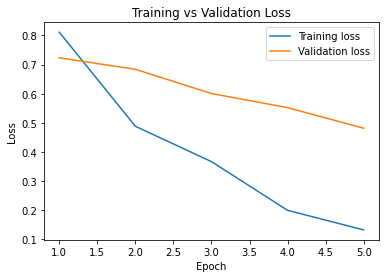

In [ ]:
plt.plot(range(1,6),training_loss,label="Training loss")
plt.plot(range(1,6),validation_loss,label="Validation loss")


plt.xlabel("Epoch") 
plt.ylabel("Loss")
title= "Training vs Validation Loss"
plt.title(title)
plt.legend()
plt.show()


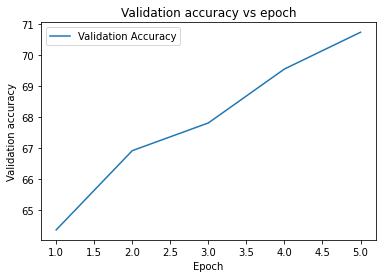

In [ ]:
plt.plot(range(1,6),accuracy,label="Validation Accuracy")


plt.xlabel("Epoch") 
plt.ylabel("Validation accuracy")
title= "Validation accuracy vs epoch"
plt.title(title)
plt.legend()
plt.show()


In [ ]:
len(df_test)

543

In [ ]:
BERT_MODEL = 'bert-base-uncased'
MAX_LEN = 160

tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL)

score=[]
text_list=[]
test_id=[]
polarity=[]
ratings = df_test.Ratings


path = "/content/drive/MyDrive/NLU2/module2/"
dir_list = os.listdir(path)
path=path+dir_list[0]
model = torch.load(path, map_location='cpu')
model= model.to(device)


for each_example in df_test.itertuples():

  id = int(each_example.id)
  text=each_example.text
  #each_example=list(each_example)
  #print(each_example)
  
  
  inputs = tokenizer.encode_plus(
      text,
      add_special_tokens = True,
      max_length = MAX_LEN,
      pad_to_max_length = True
  )
  ids = torch.tensor(inputs["input_ids"], dtype=torch.long).unsqueeze(0)
  mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).unsqueeze(0)
  token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0)

  ids = ids.to(device, dtype=torch.long)
  mask = mask.to(device, dtype=torch.long)
  token_type_ids = token_type_ids.to(device, dtype=torch.long)



  outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
  
  _, predicted = torch.max(outputs, 1)
  
  predicted = predicted.detach().cpu().numpy()
 
  predict_polarity=predicted[0]
  predict_score=outputs[0][predict_polarity].item()
  
  #append  print(predicted)
  score.append(predict_score)
  test_id.append(id)
  text_list.append(text)

  polarity.append(predicted[0])

  


In [ ]:
dict_ = {'id': test_id, 'text': text_list, 
         'polarity_score':score,'polarity':polarity,'ratings':ratings} 
df = pd.DataFrame(dict_)

In [ ]:
df.to_csv("interim_output_without_normalized.csv",index=False)

In [ ]:
list(df.polarity_score)

In [ ]:
df.polarity_score = (df.polarity_score - np.min(df.polarity_score))/(np.max(df.polarity_score)-np.min(df.polarity_score))
print(df)

        id                                               text  polarity_score  \
1509  1965  Ordered the seafood curry and it looked delici...        0.993576   
4612  3250  Same as the other locations, except that this ...        0.563739   
322      8  Its nice to support the locals vs the big chai...        0.597876   
1890  3533  """If I could give this place a negative star,...        0.751804   
2998  9699  Just left the restaurant , pretty decent frien...        0.665758   
...    ...                                                ...             ...   
1335  2430  """I used to like blue wasabi.\n\nAdmittedly, ...        0.904497   
4918  7630  **I'm posting this again, because I guess I po...        0.316672   
2414   757  The BF and I went here this morning after thin...        0.105427   
106   3857  I like their food & drinks and they have some ...        0.560699   
1129  4018  Epic fail for this place. \n\nI was just out w...        0.912641   

      polarity ratings  
15

In [ ]:
df.to_csv("interim_output.csv",index=False)

In [ ]:
df.head()

,id,text,polarity_score,polarity,ratings
1509,1965,Ordered the seafood curry and it looked delici...,0.993576,1,2
4612,3250,"Same as the other locations, except that this ...",0.563739,2,3
322,8,Its nice to support the locals vs the big chai...,0.597876,2,3
1890,3533,"""""""If I could give this place a negative star,...",0.751804,1,2
2998,9699,"Just left the restaurant , pretty decent frien...",0.665758,0,5


In [ ]:
'''
polarity =2 ratings =3
polarity =0 and poalrity_score >=0.75  ratings=5
polarity=0 and polarity_score>=0.4 and polarity_score<0.75 ratings = 4
polarity =1 and poalrity_score >=0.75  ratings=1
polarity=1 and polarity_score>=0.4 and polarity_score<0.75 ratings = 2
'''

In [ ]:
predicted_ratings=[]
for each_example in df.itertuples():

  if each_example.polarity=='2':
    predicted_ratings.append(3)

  elif each_example.polarity=='0' and each_example.polarity_score >=0.75:
    predicted_ratings.append(5)
  
  elif each_example.polarity=='0'  and each_example.polarity_score >=0.4  and each_example.polarity_score <0.75:
    predicted_ratings.append(4)
  
  elif each_example.polarity=='1' and each_example.polarity_score >=0.75:
    predicted_ratings.append(1)

  elif each_example.polarity=='1'  and each_example.polarity_score >=0.4  and each_example.polarity_score <0.75:
    predicted_ratings.append(2)


  else:
    predicted_ratings.append(2)

df['predicted_ratings']=predicted_ratings

In [ ]:
df.to_csv("final_result.csv",index=False)